# Conveyor Belt Thermodynamic Integration with Ensembler
In this notebook, we give examples how to run conveyor belt simulations with Ensembler. 

Maintainers: [@SchroederB](https://https://github.com/SchroederB), [@linkerst](https://https://github.com/linkerst), [@dfhahn](https://https://github.com/dfhahn)

## Loading Ensembler and necessary external packages 

In [1]:
import os, sys
sys.path.append(os.getcwd()+"/..")

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import colorbar
from mpl_toolkits.mplot3d import Axes3D

import ensembler.potentials.OneD as pot
import ensembler.system.perturbed_system as system
import ensembler.ensemble.replicas_dynamic_parameters as cvb
from ensembler.samplers import stochastic

## Interactive Example

In [2]:
from ensembler.visualisation.interactive_plots import interactive_conveyor_belt

iwidget = interactive_conveyor_belt(nbins=10, numsys=3, steps=10)

Simulation:  Simulation: 100%|██████████| 10/10 [00:00<00:00, 1579.48it/s]


## Build a conveyor belt object
For building a `conveyorBelt` object, you first have to build a `system`, which will be used as a template for the replicas. The `system` itself needs to to be initialized with a potential and an integrator. For details, see the Tutorial Simulations.

In [24]:
sampler = stochastic.metropolisMonteCarloIntegrator()
potential = pot.linearCoupledPotentials(Va = pot.harmonicOscillatorPotential(x_shift=0.0),
    Vb = pot.harmonicOscillatorPotential(x_shift=2.0))
sys = system.perturbedSystem(potential=potential , 
                              sampler=sampler)

Additional the number of replicas `n_replicas` and the initial capital Lambda value needs to be specified. The latter can usually be set to 0. An additional (optional) argument is the `build` variable, which will be discussed later.

The output shows the current state of the conveyor belt as a table with the replica ID, the corresponding lambda value and the energy of the replica.

In [25]:
ensemble = cvb.conveyorBelt(capital_lambda=0.0,
                n_replicas=8)
ensemble

Simulation:  Simulation: 100%|██████████| 10/10 [00:00<00:00, 610.40it/s]


i    lambda_i  E_i       
-------------------------
    0      0.00     2.176
    1      0.25     0.008
    2      0.50     2.080
    3      0.75     0.107
    4      1.00     0.363
    5      0.75     1.293
    6      0.50     6.318
    7      0.25     2.811

## Start a conveyor belt simulation 
The conveyor belt is simulated by using its member function `simulate` with the number of steps as argument. 

In [ ]:
steps = 1000
ensemble.simulate(steps)

The trajectories of the ensemble `cvb_traj` and the single systems `sys_trajs` can be retrieved by using its member function `get_trajs`.

In [9]:
(cvb_traj, systrajs) = ensemble.get_trajs()

The ensemble trajectory is a `pandas.DataFrame` object with the following columns:
- **Step**: index of frame (starting from 1)
- **capital_lambda**: the capital lambda of the frame
- **TotE**: the current total energy of the ensemble
- **biasE**: the current bias energy
- **doAccept**: information whether the Monte Carlo step before the frame was accepted or not

In [10]:
cvb_traj.head()

,Step,capital_lambda,TotE,biasE,doAccept
0,0,0.000000,7.293862,0.0,True
1,0,0.445760,7.293862,0.0,True
2,1,5.951714,16.315100,0.0,True
3,2,5.640571,7.497002,0.0,True
4,3,5.894693,10.492954,0.0,True


The system trajectory object `systrajs` is a `list` of `pandas.DataFrame` objects (one per replica) with the following columns:
- **position**: (spatial) position of particle
- **temperature**: temperature
- **total_system_energy**: the current total energy of the replica
- **total_potential_energy**: the current potential energy of the replica
- **total_kinetic_energy**: the current kinetic energy of the replica
- **dhdpos**: the derivative of the hamiltonian with repect to the position (negative of the force)
- **velocity**: velocity of the particle
- **lam**: lambda value of the particle
- **dhdlam**: Hamiltonian derivative with respect to lambda
The kinetic energy and the velocity are `NaN` in the following, becauce this example uses the stochastic `metropolisMonteCarloIntegrator`, which does not calculate velocities.

In [22]:
systrajs[0].head()

,position,temperature,total_system_energy,total_potential_energy,total_kinetic_energy,dhdpos,velocity,lam,dhdlam
0,0.5585504729220228,300.0,0.155989,0.155989,NaN,0.5602450064699949,NaN,0.000000,1.559893
1,0.2549966910418924,300.0,0.078642,0.078642,NaN,-0.3035537818801304,NaN,0.141890,0.325117
2,-0.19420972819986315,300.0,0.038757,0.038757,NaN,-0.44920641924175553,NaN,0.105511,0.188587
3,1.6720404011159127,300.0,4.257189,4.257189,NaN,1.8662501293157758,NaN,0.204551,13.978596
4,2.0482107352194046,300.0,4.691475,4.691475,NaN,0.37617033410349165,NaN,0.123661,20.975836


## Visualizations of the trajectories

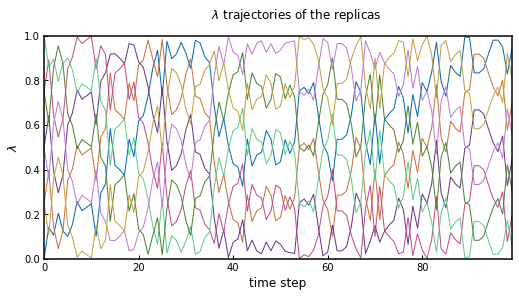

In [12]:
fig = plt.figure(figsize=(10,4))
for i in systrajs:
    plt.plot(systrajs[i].index[:100], systrajs[i].lam[:100], label=f"{i}")
plt.xlabel("time step")
plt.ylabel("$\lambda$")
out = plt.suptitle("$\lambda$ trajectories of the replicas", x=.6, y=1.0)

## Simple analysis of the conveyor belt simulation
We sort the combined dhdlam trajectories from all replicas according to the associated lambda value. Then, we calculate the average per bin, which gives you the `<dhdlam>`(lam) estimate at point `lam`. In the following we use `nbins=100`, but you can adapt it according to your sampled data.

In [19]:
nbins=100
bins=np.zeros(nbins)
dhdlbins=np.zeros(nbins)
for i in systrajs:
    for j in range(systrajs[i].shape[0]):
        index=int(np.floor(systrajs[i].lam[j]*nbins))
        if index == nbins:
            index=nbins-1
        bins[index]+=1
        dhdlbins[index]+=systrajs[i].dhdlam[j]
# avoid division by zero by setting elements == 0 to 1
bins = np.where(bins, bins, 1)
dhdlbins/=bins

The plotted `<dhdlam>(lam)` curve is similar to the curves you get from TI simulations, but is usually base on more lambda points. 

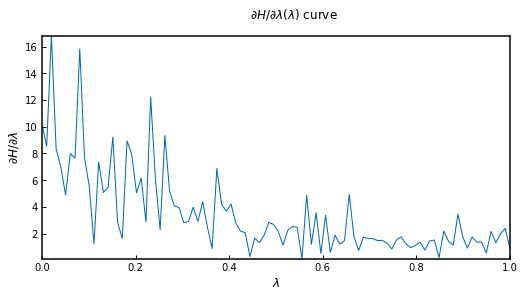

In [20]:
fig = plt.figure(figsize=(10,4))
plt.plot(np.linspace(0,1,nbins), dhdlbins)
plt.xlabel("$\lambda$")
plt.ylabel("$\partial H / \partial \lambda$")
out = plt.suptitle("$\partial H / \partial \lambda (\lambda)$ curve", x=.6, y=1.0)

The integral of this curve gives the free energy estimate. As you have many points along $\lambda$, you can use the rectangular integration:

In [21]:
integral=np.sum(dhdlbins)*1.0/nbins
print('Integral = ', integral)

Integral =  3.478790455992348


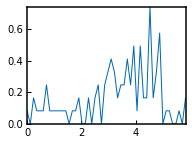

In [15]:
h1=np.histogram(cvb_traj.capital_lambda, bins=50, density=1)
plt.plot(h1[1][:-1], h1[0])
#plt.ylim(0.14, 0.185)

Text(0, 0.5, '$\\lambda$')

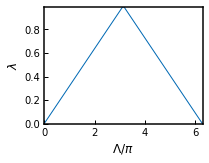

In [16]:
caplam = np.linspace(0, 2*np.pi, 100)
x=[]
for i in caplam:
    x.append(ensemble.calculate_replica_lambda(i, 0))
plt.plot(caplam, x)
plt.xlabel('$\Lambda / \pi$')
plt.ylabel('$\lambda$')

In [17]:
#analytical
u=1.66053886e-27
NA=6.0221415e23
hbar=1.054571800e-34*1e12*1e-3*NA  #kJ/mol*ps
R=0.00831446 #kJ/mol/K
mu=0.5  #u
T=300.0  #K
fc1=1  #kJ/nm^2/mol
fc2=11.0 #kJ/nm^2/mol
omega1=np.sqrt(fc1/mu)
omega2=np.sqrt(fc2/mu)
print('Omega', omega1, omega2)
alpha1=hbar*np.sqrt(fc1/mu)/(R*T)
alpha2=hbar*np.sqrt(fc2/mu)/(R*T)
print(alpha1, alpha2)
Z1=np.exp(-alpha1/2.0)/(1-np.exp(-alpha1))
Z2=np.exp(-alpha2/2.0)/(1-np.exp(-alpha2))
F1=-R*T*np.log(Z1)
F2=-R*T*np.log(Z2)
DF=F2-F1
DF2=-R*T*np.log(Z2/Z1)
print(DF, DF2, F1, F2)

Omega 1.4142135623730951 4.69041575982343
0.03600698886161772 0.11942167188449208
2.991927940369414 2.991927940369415 -8.291150088634001 -5.299222148264588


## Conveyor Belt Animation

IndexError: index 1 is out of bounds for axis 0 with size 1

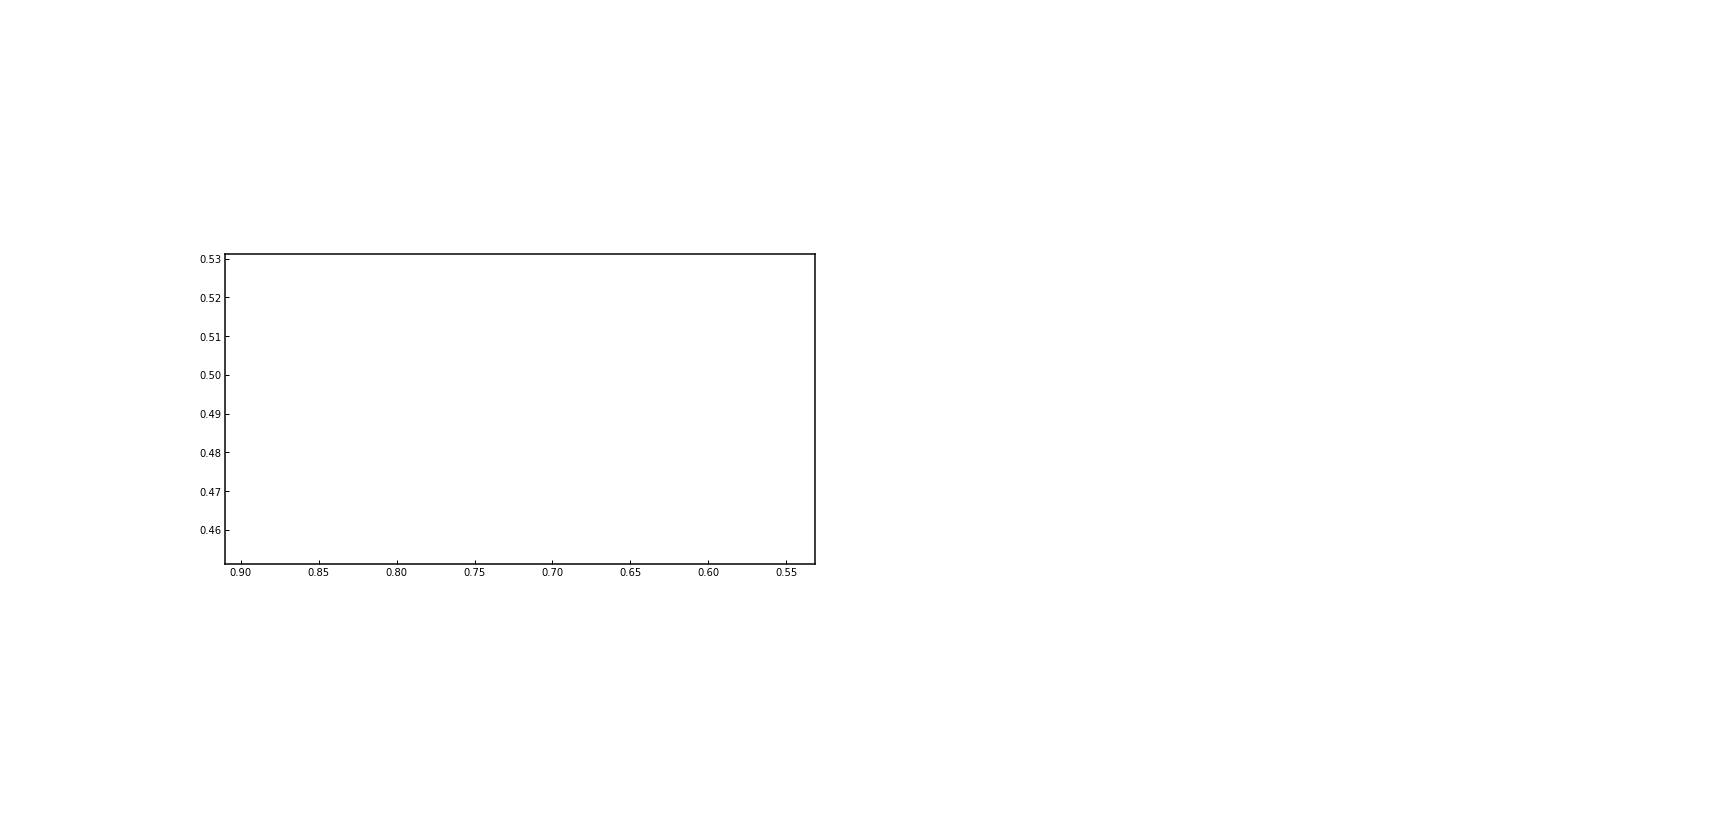

In [19]:
import ensembler.visualisation.plotConveyorBelt as plotEnsembler
nbins=2
dhdlbins=2
lam = np.linspace(0, 1, nbins)
ene = np.cumsum(dhdlbins)/nbins

fig = plotEnsembler.plotEnsembler(lam, ene, CapLam=0.2, M=8)